# Bayesian optimization

This tutorial is an introduction to the syntax used by the optimizer, as well as the principles of Bayesian optimization in general.

We'll start by minimizing the Rastrigin function in one dimension, which looks like this:

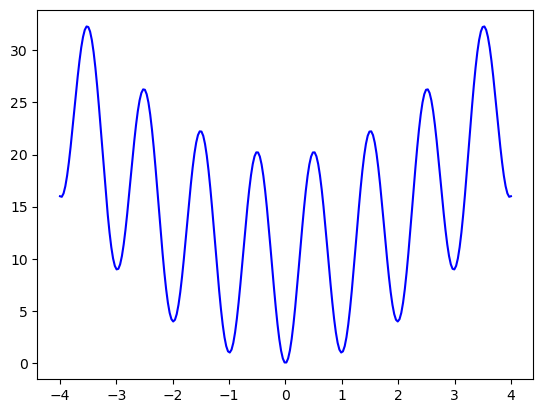

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

from bloptools import test_functions

x = np.linspace(-4, 4, 256)

plt.plot(x, test_functions.rastrigin(x), c="b")

There are several things that our agent will need. The first ingredient is some degrees of freedom (these are always `ophyd` devices) which the agent will move around to different inputs within each DOF's bounds (the second ingredient). We define these here:

In [2]:
import bloptools

dofs = bloptools.devices.dummy_dofs(n=1)  # an ophyd device that we can read/set

bounds = [(-4.0, 4.0)]  # one set of bounds per dof

This degree of freedom will move around a variable called `x1`. The agent automatically samples at different inputs, but we often need some post-processing after data collection. In this case, we need to give the agent a way to compute the Rastrigin function. We accomplish this with a digestion function, which always takes `(db, uid)` as an input. For each entry, we compute the function:


In [3]:
def digestion(db, uid):
    products = db[uid].table()

    for index, entry in products.iterrows():
        products.loc[index, "rastrigin"] = test_functions.rastrigin(entry.x1)

    return products

The next ingredient is a task, which gives the agent something to do. We want it to minimize the Rastrigin function, so we make a task that will try to minimize the output of the digestion function called "rastrigin".

In [4]:
from bloptools.tasks import Task

task = Task(key="rastrigin", kind="min")

Combining all of these with a databroker instance, we can make an agent:

In [5]:
%run -i ../../../examples/prepare_bluesky.py # prepare the bluesky environment

agent = bloptools.bayesian.Agent(
    active_dofs=dofs,
    passive_dofs=[],
    active_dof_bounds=bounds,
    tasks=[task],
    digestion=digestion,
    db=db,
)

RE(agent.initialize(acqf="qr", n_init=12))



Transient Scan ID: 1     Time: 2023-07-16 19:51:01
Persistent Unique Scan ID: '85b647ca-1df4-476d-a68f-345f7eeed4f7'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |         x1 |
+-----------+------------+------------+
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
+-----------+------------+------------+
generator list_scan ['85b647ca'] (scan num: 1)





/usr/share/miniconda3/envs/bloptools-py3.10/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


('85b647ca-1df4-476d-a68f-345f7eeed4f7',)

We initialized the GP with the "quasi-random" strategy, as it doesn't require any prior data. We can view the state of the optimizer's posterior of the tasks over the input parameters:

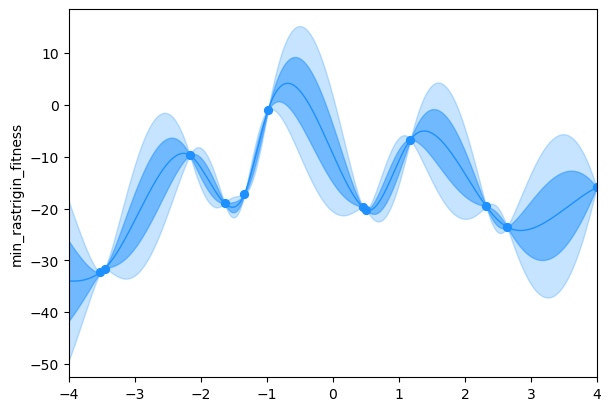

In [6]:
# what are the points?

agent.plot_tasks()

Note that the value of the fitness is the negative value of the function: we always want to maximize the fitness of the tasks.

An important concept in Bayesian optimization is the acquisition function, which is how the agent decides where to sample next. Under the hood, the agent will see what inputs maximize the acquisition function to make its decision.

We can see what the agent is thinking by asking it to plot a few different acquisition functions in its current state.

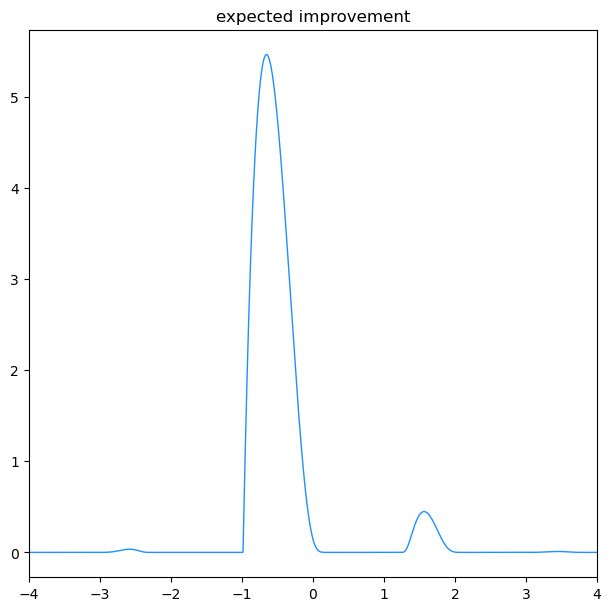

In [7]:
# helper function to list acquisition functions

agent.plot_acquisition(strategy=["ei", "pi", "ucb"])

Let's tell the agent to learn a little bit more. We just have to tell it what acquisition function to use (by passing a `strategy`) and how many iterations we'd like it to perform (by passing `n_iter`).



Transient Scan ID: 2     Time: 2023-07-16 19:51:06
Persistent Unique Scan ID: 'a5c4e6e1-9617-493f-b682-6fe32b8d01d1'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |         x1 |
+-----------+------------+------------+
|         1 | 19:51:06.4 |     -0.653 |
+-----------+------------+------------+
generator list_scan ['a5c4e6e1'] (scan num: 2)





/usr/share/miniconda3/envs/bloptools-py3.10/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)




Transient Scan ID: 3     Time: 2023-07-16 19:51:09
Persistent Unique Scan ID: 'e2036ae7-cf6b-4fbe-9ecc-013629aca586'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |         x1 |
+-----------+------------+------------+
|         1 | 19:51:09.5 |      1.583 |
+-----------+------------+------------+
generator list_scan ['e2036ae7'] (scan num: 3)





/usr/share/miniconda3/envs/bloptools-py3.10/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)




Transient Scan ID: 4     Time: 2023-07-16 19:51:12
Persistent Unique Scan ID: 'd5e40c08-d970-4bdb-a00c-4410ba3b16ac'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |         x1 |
+-----------+------------+------------+
|         1 | 19:51:12.4 |     -2.600 |
+-----------+------------+------------+
generator list_scan ['d5e40c08'] (scan num: 4)





/usr/share/miniconda3/envs/bloptools-py3.10/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)




Transient Scan ID: 5     Time: 2023-07-16 19:51:15
Persistent Unique Scan ID: 'dad3c25b-5683-4ff1-9584-7018d06c4c99'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |         x1 |
+-----------+------------+------------+
|         1 | 19:51:15.2 |      3.436 |
+-----------+------------+------------+
generator list_scan ['dad3c25b'] (scan num: 5)





/usr/share/miniconda3/envs/bloptools-py3.10/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)




Transient Scan ID: 6     Time: 2023-07-16 19:51:18
Persistent Unique Scan ID: '3a72b0fd-ed59-4cf6-bad2-72950899f961'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |         x1 |
+-----------+------------+------------+
|         1 | 19:51:18.2 |     -0.942 |
+-----------+------------+------------+
generator list_scan ['3a72b0fd'] (scan num: 6)





/usr/share/miniconda3/envs/bloptools-py3.10/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)




Transient Scan ID: 7     Time: 2023-07-16 19:51:21
Persistent Unique Scan ID: '8c2393cc-9a22-4b58-b9af-ac0249590d79'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |         x1 |
+-----------+------------+------------+
|         1 | 19:51:21.2 |     -1.017 |
+-----------+------------+------------+
generator list_scan ['8c2393cc'] (scan num: 7)





/usr/share/miniconda3/envs/bloptools-py3.10/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)




Transient Scan ID: 8     Time: 2023-07-16 19:51:24
Persistent Unique Scan ID: '8791966f-c754-4270-a54d-f45b4a83b9b8'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |         x1 |
+-----------+------------+------------+
|         1 | 19:51:24.3 |      0.976 |
+-----------+------------+------------+
generator list_scan ['8791966f'] (scan num: 8)





/usr/share/miniconda3/envs/bloptools-py3.10/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)




Transient Scan ID: 9     Time: 2023-07-16 19:51:27
Persistent Unique Scan ID: '7c336344-d07e-438b-a5f8-7467b8ac14f5'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |         x1 |
+-----------+------------+------------+
|         1 | 19:51:27.1 |      1.013 |
+-----------+------------+------------+
generator list_scan ['7c336344'] (scan num: 9)





/usr/share/miniconda3/envs/bloptools-py3.10/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


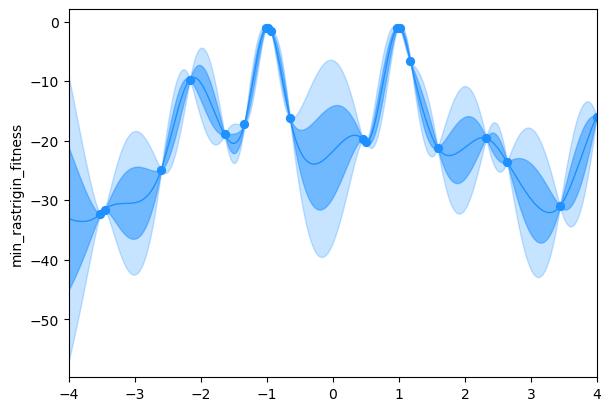

In [8]:
RE(agent.learn(acqf="ei", n_iter=8))
agent.plot_tasks()